In [2]:
%load_ext autoreload
%autoreload 2

import numpy as np
from utils.data import prepare_dataset, balance_dataset

In [3]:
image_dir_train = 'web_dataset/train/images'
gt_dir_train = 'web_dataset/train/ground_truth'

image_dir_test = 'web_dataset/test/images'
gt_dir_test = 'web_dataset/test/ground_truth'

X_train, y_train = prepare_dataset(image_dir_train, gt_dir_train, r=3, use_bw=True, use_ST=True, pos_dup_factor=5, verbose=True)

X_test, y_test = prepare_dataset(image_dir_test, gt_dir_test, r=3, use_bw=True, use_ST=True, pos_dup_factor=5, verbose=True)

Processed web_dataset/train/images/R_GImag0001.bmp (50700 data points)
Processed web_dataset/train/images/R_GImag0002.bmp (143433 data points)
Processed web_dataset/train/images/R_GImag0003.bmp (83405 data points)
Processed web_dataset/train/images/R_GImag0004.bmp (54532 data points)
Processed web_dataset/train/images/R_GImag0005.bmp (120449 data points)
Processed web_dataset/train/images/R_GImag0006.bmp (148501 data points)
Processed web_dataset/train/images/R_GImag0007.bmp (125797 data points)
Processed web_dataset/train/images/R_GImag0008.bmp (70995 data points)
Processed web_dataset/train/images/R_GImag0009.bmp (170964 data points)
Processed web_dataset/train/images/R_GImag0010.bmp (97218 data points)
Processed web_dataset/train/images/R_GImag0011.bmp (95098 data points)
Processed web_dataset/train/images/R_GImag0012.bmp (14411 data points)
Processed web_dataset/train/images/R_GImag0013.bmp (157825 data points)
Processed web_dataset/train/images/R_GImag0014.bmp (141349 data points)

In [4]:
print("Train set:")
print("   Features shape:", X_train.shape)
print("   Labels shape:", y_train.shape)
print("   Positive samples:", np.sum(y_train))
print("   Negative samples:", len(y_train) - np.sum(y_train))

print("Test set:")
print("   Features shape:", X_test.shape)
print("   Labels shape:", y_test.shape)
print("   Positive samples:", np.sum(y_test))
print("   Negative samples:", len(y_test) - np.sum(y_test))

Train set:
   Features shape: (6285181, 52)
   Labels shape: (6285181,)
   Positive samples: 523290
   Negative samples: 5761891
Test set:
   Features shape: (1383131, 52)
   Labels shape: (1383131,)
   Positive samples: 139660
   Negative samples: 1243471


In [5]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class RidgeClassifier(nn.Module):
    def __init__(self, in_dim):
        super().__init__()
        self.fc1 = nn.Linear(in_dim, 16)
        self.fc3 = nn.Linear(16, 1)
    def forward(self,x):
        x = F.relu(self.fc1(x))
        return torch.sigmoid(self.fc3(x))

In [ ]:
from torch.utils.data import TensorDataset, DataLoader

X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.float32).view(-1, 1)  # for binary classification
X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test, dtype=torch.float32).view(-1, 1)

train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

In [7]:
from utils.training import train_model

model = train_model(RidgeClassifier, input_dim=X_test.shape[1], train_loader=train_loader, test_loader=test_loader, lr = 0.003, epochs=5)

Epoch 1: Train Loss = 0.0842, Test Loss = 0.1390, Accuracy = 95.55%
Epoch 2: Train Loss = 0.0794, Test Loss = 0.1415, Accuracy = 94.64%
Epoch 3: Train Loss = 0.0774, Test Loss = 0.1284, Accuracy = 95.56%
Epoch 4: Train Loss = 0.0763, Test Loss = 0.1332, Accuracy = 95.78%
Epoch 5: Train Loss = 0.0756, Test Loss = 0.1229, Accuracy = 96.00%


In [60]:

from utils.line_prediction import generate_probability_map
from utils.data import compute_ST_map
import cv2

# Load image
img_path = "web_dataset/test/images/R_GImag0070.bmp"
image = cv2.imread(img_path)

image_gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

ST_values = compute_ST_map(image_gray)

prob_map = generate_probability_map(image_gray, model, ST_map=ST_values, r = 3)

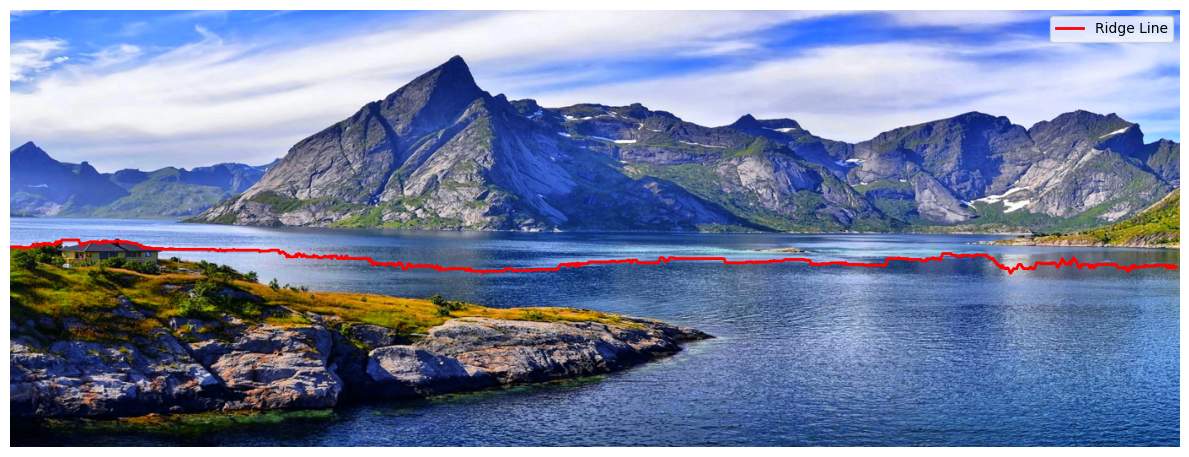

In [61]:
from utils.line_prediction import find_ridge_greedy

ridge = find_ridge_greedy(image_gray, model, search_r=3, ST_map=ST_values, r = 3, restart_threshold=0.7)

def plot_ridge(image, ridge):
    plt.figure(figsize=(12, 6))
    plt.imshow(image)
    plt.plot(range(len(ridge)), ridge, color='red', linewidth=2, label='Ridge Line')
    plt.axis('off')
    plt.legend()
    plt.tight_layout()
    plt.show()

plot_ridge(cv2.cvtColor(image, cv2.COLOR_BGR2RGB), ridge)

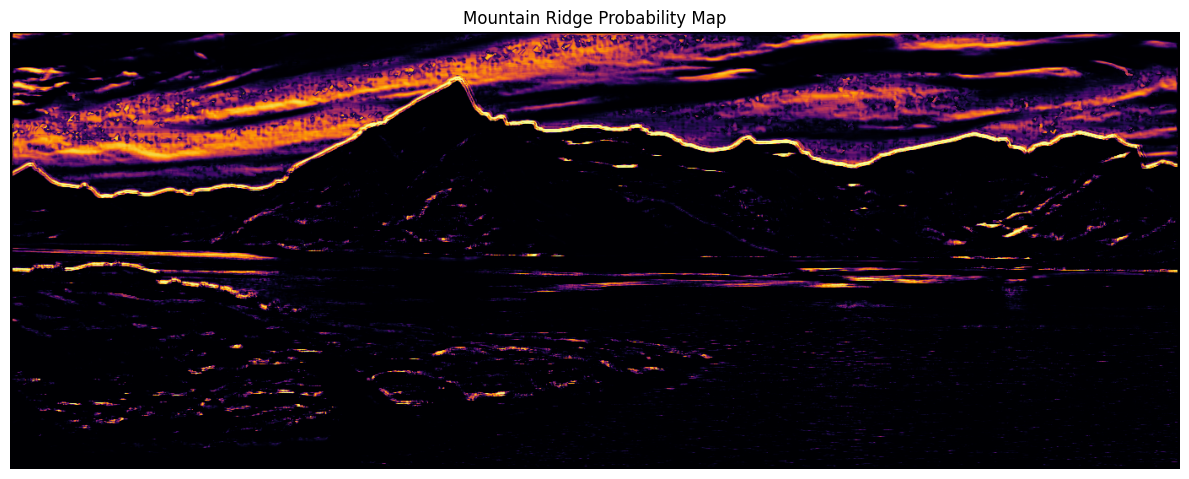

In [62]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 5))

plt.title("Mountain Ridge Probability Map")
plt.imshow(prob_map, cmap='inferno', vmin=0, vmax=1)
plt.axis('off')

plt.tight_layout()
plt.show()

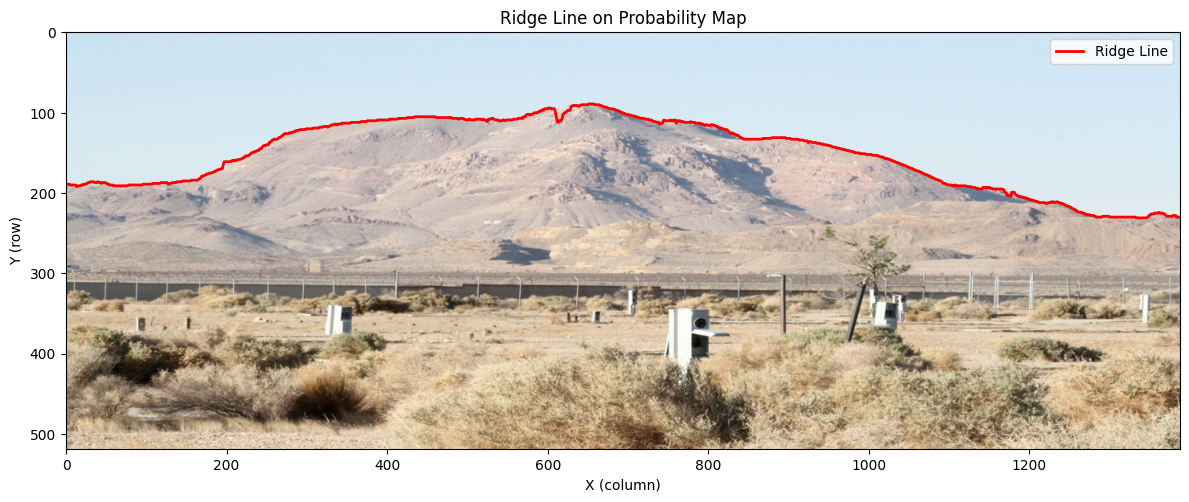

In [ ]:
from utils.line_prediction import find_ridge_DP_Canny

ridge = find_ridge_DP_Canny(image_gray, model, ST_map=ST_values, r = 3)

def plot_ridge(image, ridge):
    plt.figure(figsize=(12, 6))
    plt.imshow(image)
    plt.plot(range(len(ridge)), ridge, color='red', linewidth=2, label='Ridge Line')
    plt.title('Ridge Line on Probability Map')
    plt.xlabel('X (column)')
    plt.ylabel('Y (row)')
    plt.legend()
    plt.tight_layout()
    plt.show()

plot_ridge(cv2.cvtColor(image, cv2.COLOR_BGR2RGB), ridge)

In [ ]:
from utils.ridge_evaluation import evaluate_ridge_predictions
from utils.line_prediction import find_ridge_DP_Canny  # or find_ridge_greedy
import os
import cv2

image_paths = sorted([os.path.join(image_dir_test, f) for f in os.listdir(image_dir_test) if f.endswith('.bmp')])
gt_paths = sorted([os.path.join(gt_dir_test, f) for f in os.listdir(gt_dir_test) if f.endswith('.bmp')])

results = evaluate_ridge_predictions(
    image_paths=image_paths,
    gt_paths=gt_paths,
    model=model,
    find_ridge_fn=find_ridge_DP_Canny,  # or find_ridge_greedy
    r=3,
    use_ST=True
)

print("Evaluation Results:")
for k, v in results.items():
    print(f"{k}: {v:.4f}")

Evaluating: 100%|██████████| 15/15 [01:22<00:00,  5.47s/it]

Evaluation Results:
avg_pixel_distance: 1.6165
cosine_similarity: 0.9991
avg_inference_time: 5.3989


In [218]:
results = evaluate_ridge_predictions(
    image_paths=image_paths,
    gt_paths=gt_paths,
    model=model,
    find_ridge_fn=find_ridge_greedy,  # or find_ridge_greedy
    r=3,
    use_ST=True
)

Evaluating: 100%|██████████| 15/15 [00:05<00:00,  2.98it/s]


In [219]:
print("Evaluation Results:")
for k, v in results.items():
    print(f"{k}: {v:.4f}")

Evaluation Results:
avg_pixel_distance: 23.9540
cosine_similarity: 0.9914
avg_inference_time: 0.2745


Comparisons needed
- BW vs RBG
- Orginal vs ST
- DP vs Greed

Criteria
- Avg Pixel Dist
- Cosine Similarity
- Runtime



In [ ]:
configs = [
    {"name": "gray_noST", "use_bw": True,  "use_ST": False},
    {"name": "color_noST", "use_bw": False, "use_ST": False},
    {"name": "gray_ST",   "use_bw": True,  "use_ST": True},
    {"name": "color_ST",  "use_bw": False, "use_ST": True},
]

results = []

for cfg in configs:
    print(f"Running config: {cfg['name']}")

    # prep data
    X_train, y_train = prepare_dataset(image_dir_train, gt_dir_train, r=3, use_bw=cfg['use_bw'], use_ST=cfg['use_ST'], pos_dup_factor=5)
    X_test, y_test = prepare_dataset(image_dir_test, gt_dir_test, r=3, use_bw=cfg['use_bw'], use_ST=cfg['use_ST'], pos_dup_factor=5)

    # dataloader
    X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
    y_train_tensor = torch.tensor(y_train, dtype=torch.float32).view(-1, 1)  # for binary classification
    X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
    y_test_tensor = torch.tensor(y_test, dtype=torch.float32).view(-1, 1)

    train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
    test_dataset = TensorDataset(X_test_tensor, y_test_tensor)

    train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
    test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

    # train
    model = train_model(RidgeClassifier, input_dim=X_train.shape[1], train_loader=train_loader, test_loader=test_loader, lr=0.003, epochs=5)

    # evaluate both methods
    for method_name, find_ridge_fn in [("DP", find_ridge_DP_Canny), ("Greedy", find_ridge_greedy)]:
        eval_result = evaluate_ridge_predictions(image_paths, gt_paths, model, find_ridge_fn=find_ridge_fn, r=3, use_ST=cfg['use_ST'], use_bw=cfg['use_bw'])

        results.append({
            "config": cfg["name"],
            "method": method_name,
            **eval_result
        })

Running config: gray_noST
Epoch 1: Train Loss = 0.0872, Test Loss = 0.1354, Accuracy = 95.09%
Epoch 2: Train Loss = 0.0819, Test Loss = 0.1422, Accuracy = 95.43%
Epoch 3: Train Loss = 0.0807, Test Loss = 0.1409, Accuracy = 94.78%
Epoch 4: Train Loss = 0.0802, Test Loss = 0.1346, Accuracy = 95.36%
Epoch 5: Train Loss = 0.0798, Test Loss = 0.1388, Accuracy = 95.22%


Evaluating: 100%|██████████| 15/15 [00:04<00:00,  3.72it/s]


Running config: color_noST
Epoch 1: Train Loss = 0.0435, Test Loss = 0.1062, Accuracy = 96.45%
Epoch 2: Train Loss = 0.0392, Test Loss = 0.0900, Accuracy = 96.73%
Epoch 3: Train Loss = 0.0376, Test Loss = 0.0926, Accuracy = 97.03%
Epoch 4: Train Loss = 0.0362, Test Loss = 0.0858, Accuracy = 97.11%
Epoch 5: Train Loss = 0.0357, Test Loss = 0.0905, Accuracy = 97.10%


Evaluating: 100%|██████████| 15/15 [00:04<00:00,  3.46it/s]


Running config: gray_ST
Epoch 1: Train Loss = 0.0827, Test Loss = 0.1341, Accuracy = 95.33%
Epoch 2: Train Loss = 0.0789, Test Loss = 0.1288, Accuracy = 95.78%
Epoch 3: Train Loss = 0.0777, Test Loss = 0.1309, Accuracy = 95.37%
Epoch 4: Train Loss = 0.0768, Test Loss = 0.1267, Accuracy = 95.77%
Epoch 5: Train Loss = 0.0753, Test Loss = 0.1252, Accuracy = 95.93%


Evaluating: 100%|██████████| 15/15 [00:05<00:00,  2.88it/s]


Running config: color_ST
Epoch 1: Train Loss = 0.0434, Test Loss = 0.1125, Accuracy = 96.38%
Epoch 2: Train Loss = 0.0393, Test Loss = 0.1231, Accuracy = 96.59%
Epoch 3: Train Loss = 0.0386, Test Loss = 0.1105, Accuracy = 96.98%
Epoch 4: Train Loss = 0.0382, Test Loss = 0.1134, Accuracy = 96.85%
Epoch 5: Train Loss = 0.0379, Test Loss = 0.1189, Accuracy = 96.83%


Evaluating: 100%|██████████| 15/15 [00:05<00:00,  2.90it/s]


In [224]:
import pandas as pd

df_results = pd.DataFrame(results)
print(df_results.sort_values(by=['config', 'method']))

       config  method  avg_pixel_distance  cosine_similarity  \
6    color_ST      DP            0.900240           0.999195   
7    color_ST  Greedy           20.653131           0.995870   
2  color_noST      DP            0.891402           0.999195   
3  color_noST  Greedy           10.986657           0.978704   
4     gray_ST      DP            1.588713           0.999135   
5     gray_ST  Greedy           32.812091           0.963148   
0   gray_noST      DP            1.618924           0.999136   
1   gray_noST  Greedy            8.633622           0.991637   

   avg_inference_time  
6            5.522724  
7            0.282634  
2            5.359985  
3            0.277066  
4            5.565312  
5            0.282215  
0            5.309818  
1            0.258012  


In [ ]:
import matplotlib.pyplot as plt
import numpy as np

def plot_grouped_bar(df, metric, title=None):
    configs = df['config'].unique()
    methods = df['method'].unique()

    values = np.array([
        [df[(df['config'] == cfg) & (df['method'] == m)][metric].values[0]
         for m in methods]
        for cfg in configs
    ])

    x = np.arange(len(configs))
    width = 0.35

    colors = {
        'DP': '#2a4c55',
        'Greedy': '#e2af43'
    }

    fig, ax = plt.subplots(figsize=(5, 3))
    for i, method in enumerate(methods):
        ax.bar(x + i*width, values[:, i], width, label=method, color=colors.get(method, None))

    ax.set_xticks(x + width/2)
    ax.set_xticklabels(configs)
    ax.set_ylabel(metric.replace('_', ' ').title())
    ax.set_title(title or f"Comparison of {metric.replace('_', ' ').title()}")
    ax.legend()
    plt.tight_layout()
    plt.show()

plot_grouped_bar(df_results, metric='avg_pixel_distance')
plot_grouped_bar(df_results, metric='cosine_similarity')
plot_grouped_bar(df_results, metric='avg_inference_time')


NameError: name 'df_results' is not defined